# Multiple Sclerosis Classifier

This notebook contains a simple classifier for multiple sclerosis (MS) based on gene expression data. The goal of this project is to learn how to write a simple classifier for healthy and unhealthy patients.

The data is from a study comparing gene expression in peripheral blood samples between healthy human individuals and patients with relapsing-remitting multiple sclerosis (RRMS). The data was generated using RNA sequencing (RNA-Seq) to identify differences in mRNA levels between the two groups.

If you prefer you can use alternative datasets, classifying different diseases. Data can be acquired [here](https://www.ebi.ac.uk/gxa/experiments?experimentType=%22Differential%22&species=homo+sapiens). 
Choose datasets with at least two experimental factors. 
The default dataset (MS) was from [this](https://www.ebi.ac.uk/gxa/experiments/E-GEOD-66573/Results) link.
In case you are unsure how to handle different datasets, an alternative [dataset](https://www.ebi.ac.uk/gxa/experiments/E-ENAD-46/Results) is included as an example and can be loaded by changing `DATASET = lung` further below.


## Data Files

The data is located in the `data/` folder and consists of two datasets: Multiple Sclerosis (MS) and Lung.

### Multiple Sclerosis (MS)

The MS data is located in the `data/ms/` folder and consists of the following files:

*   `data/ms/raw-counts.tsv`: This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.
*   `data/ms/experiment-design.tsv`: This file describes the samples, indicating which ones are from healthy controls and which are from RRMS patients, along with other relevant metadata.
*   `data/ms/query-results.tsv`: This file contains the query results from the Expression Atlas database.

### Lung

The Lung data is located in the `data/lung/` folder and consists of the following files:

*   `data/lung/raw-counts.tsv`: This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.
*   `data/lung/experiment-design.tsv`: This file describes the samples and their metadata.
*   `data/lung/query-results.tsv`: This file contains the query results from the Expression Atlas database.

### Your Tasks

Your main task is to improve the classifier by selecting better features. This involves the following steps:

1.  **Familiarize yourself with the covariance matrix:** The covariance matrix is a powerful tool for understanding the relationships between features. The current version of this notebook generates a covariance matrix for the first 5 genes.
2.  **Normalization:** The data is normalized before calculating the covariance matrix. Why is this important? What would happen if you didn't normalize the data?
3.  **Feature Selection:** The current version of the notebook only uses the first 5 genes as features. You should experiment with different sets of features to see if you can improve the accuracy of the classifier. You can use the information from the `query results` dataframe to select genes that are differentially expressed between the two groups.
4.  **Interpret the covariance matrix:** What does it mean if a value in the covariance matrix is close to 0? What does it mean if it is close to 1? How can you use this information to select features?
5.  **Implement k-fold cross validation:** Since we have limited data (only 14 samples total), a single train/test split may not give us a reliable estimate of model performance. Implement k-fold cross validation to get a more robust evaluation of your classifier. Consider what value of k would be appropriate given our small dataset size. Compare the results from k-fold cross validation with the simple train/test split approach currently used in the notebook.

In [979]:
# Ensure that packages are installed
!pip install pandas scikit-learn matplotlib numpy
!pip install seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Raw Counts

This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.

### Select the dataset to use

In [980]:
DATASET = "data" # or "lung"

In [981]:
DATA_DIR = DATASET  #f"data/{DATASET}"

In [982]:
# Remove all genes with 0 expression in all 14 samples

df_raw_counts = pd.read_csv(f"{DATA_DIR}/raw-counts.tsv", sep="\t", index_col=0)
df_raw_counts
df_raw_counts = df_raw_counts.apply(pd.to_numeric, errors='coerce')
df_filtered = df_raw_counts.loc[df_raw_counts.nunique(axis=1) > 1]
#df_filtered = df_filtered[(df_filtered > 5).any(axis=1)]
print("Original number of genes:", df_raw_counts.shape[0])
print("Filtered number of genes:", df_filtered.shape[0])
print("Removed:", df_raw_counts.shape[0] - df_filtered.shape[0], "genes with no expression")



Original number of genes: 58735
Filtered number of genes: 33811
Removed: 24924 genes with no expression


### Experiment Design

This file describes the samples, indicating which ones are from healthy controls and which are from RRMS patients, along with other relevant metadata.

In [983]:
df_experiment_design = pd.read_csv(f"{DATA_DIR}/experiment-design.tsv", sep="\t", index_col=0)
df_experiment_design




,Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[ethnic group],Sample Characteristic Ontology Term[ethnic group],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Factor Value[disease],Factor Value Ontology Term[disease],Analysed
Run,,,,,,,,,,,
SRR1839791,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
SRR1839792,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839793,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839794,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
SRR1839795,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839796,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839797,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839798,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839799,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes


### Query Results

This file contains the query results from the Expression Atlas database.

In [984]:
df_query_results = pd.read_csv(f"{DATA_DIR}/query-results.tsv", sep="\t", index_col=0)
df_query_results

,Gene Name,'relapsing-remitting multiple sclerosis' vs 'normal' .foldChange,'relapsing-remitting multiple sclerosis' vs 'normal'.pValue
Gene ID,,,
ENSG00000000419,DPM1,0.1,0.686278
ENSG00000000457,SCYL3,0.1,0.750671
ENSG00000000460,C1orf112,-0.4,0.348980
ENSG00000000938,FGR,0.4,0.099978
ENSG00000000971,CFH,-0.4,0.536052
...,...,...,...
ENSG00000285966,ENSG00000285966,0.9,0.070963
ENSG00000285967,NIPBL-DT,-1.0,0.005982
ENSG00000285976,ENSG00000285976,-1.1,0.042264


### Data Preparation

Before we can train a classifier, we need to prepare the data. This involves selecting features and labels from the dataframes.

In [985]:
def get_features_of_patient(df, patient_id):
    """
    Get the raw gene counts of a specific patient from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing patient data.
    patient_id (str): ID of the patient to retrieve features for. You can find the IDs in the first column of the analytics dataframe.
    
    Returns:
    pd.Series: Features of the specified patient.
    """
    return df[patient_id].to_list() 

get_features_of_patient(df_filtered, "SRR1839791")

[8,
 135,
 303,
 46,
 14749,
 74,
 251,
 336,
 707,
 58,
 774,
 433,
 242,
 1,
 0,
 585,
 9,
 165,
 179,
 0,
 137,
 526,
 1604,
 18,
 88,
 14,
 0,
 599,
 11091,
 1427,
 1304,
 1517,
 14,
 63,
 60,
 90,
 189,
 1084,
 12565,
 9,
 182,
 4015,
 28,
 2,
 1840,
 249,
 724,
 1817,
 972,
 355,
 534,
 770,
 1975,
 682,
 298,
 185,
 0,
 180,
 162,
 321,
 8,
 54,
 0,
 143,
 65,
 523,
 2875,
 208,
 562,
 9,
 5530,
 2485,
 1537,
 508,
 0,
 186,
 271,
 45,
 5,
 373,
 288,
 64,
 6,
 323,
 993,
 2307,
 17,
 590,
 1822,
 6909,
 880,
 251,
 131,
 178,
 155,
 20,
 2860,
 901,
 81,
 380,
 154,
 2052,
 1073,
 10761,
 237,
 103,
 785,
 6022,
 647,
 1140,
 801,
 14,
 553,
 1,
 1,
 1323,
 0,
 8,
 3054,
 575,
 472,
 74,
 115,
 332,
 27,
 2131,
 1,
 541,
 1292,
 292,
 436,
 0,
 227,
 43,
 118,
 51,
 1572,
 0,
 195,
 3,
 937,
 915,
 15,
 798,
 9,
 407,
 41,
 1152,
 7,
 2,
 37,
 581,
 6,
 406,
 349,
 2448,
 2,
 2,
 2242,
 0,
 2565,
 232,
 890,
 2,
 716,
 4,
 63,
 125,
 0,
 408,
 1,
 812,
 258,
 816,
 549,
 485,
 

In [986]:
def get_dataset(df_filtered, df_experiment_design): 
    """
    Get the entire dataset of features and labels.
    
    Parameters:
    df_raw_counts (pd.DataFrame): DataFrame containing raw gene counts.
    df_experiment_design (pd.DataFrame): DataFrame containing experiment design data.
    
    Returns:
    tuple: Features and labels for the dataset.
    """
    patient_ids = df_experiment_design.index.to_list()
    features = [get_features_of_patient(df_filtered, patient_id) for patient_id in patient_ids]
    labels = df_experiment_design["Sample Characteristic[disease]"].to_list()
    unique_labels = list(set(labels))
    labels = [unique_labels.index(label) for label in labels] # Convert labels to numbers
    return features, labels

features, labels = get_dataset(df_filtered, df_experiment_design)

### Train/Test Split

We split the data into a training set and a testing set. The training set is used to train the classifier, and the testing set is used to evaluate its performance. The main bottleneck we have with that project is the lack of enough data. In fact, we have 14 cases in total with 8 and 6 cases respectively. 

In [987]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.4, random_state=2)

### Train the Classifier

We use a simple Decision Tree Classifier to train the model.

In [988]:
classifier = DecisionTreeClassifier(random_state=2)
classifier = classifier.fit(train_features, train_labels)

### Evaluate the Classifier

We use the accuracy score to evaluate the performance of the classifier.

In [989]:
predicted_test_labels = classifier.predict(test_features)

In [990]:
accuracy = accuracy_score(test_labels, predicted_test_labels)

print(f"Baseline accuracy: {accuracy}")

Baseline accuracy: 0.8333333333333334


In [991]:
# Convert to numpy arrays
X_train = np.array(train_features)
X_test  = np.array(test_features)
y_train = np.array(train_labels)
y_test  = np.array(test_labels)

# ---- Select top-k genes (ANOVA F-test) ----
k = 50
selector = SelectKBest(score_func=f_classif, k=min(k, X_train.shape[1]))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected  = selector.transform(X_test)  # apply same selection to test set

# Optional: save selected gene indices
selected_gene_indices = selector.get_support(indices=True)
selected_genes = df_filtered.index[selected_gene_indices].tolist()

# ---- PCA on training data only ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled  = scaler.transform(X_test_selected)

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# ---- Model without PCA ----
model_no_pca = DecisionTreeClassifier(random_state=42)
model_no_pca.fit(X_train_scaled, y_train)
y_pred_no_pca = model_no_pca.predict(X_test_scaled)
accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)

# ---- Model with PCA ----
model_pca = DecisionTreeClassifier(random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"Test accuracy without PCA: {accuracy_no_pca:.4f}")
print(f"Test accuracy with PCA:    {accuracy_pca:.4f}")

Test accuracy without PCA: 0.5000
Test accuracy with PCA:    0.8333


c:\Users\46705\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [   26    43    74 ... 33801 33805 33806] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\46705\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\46705\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


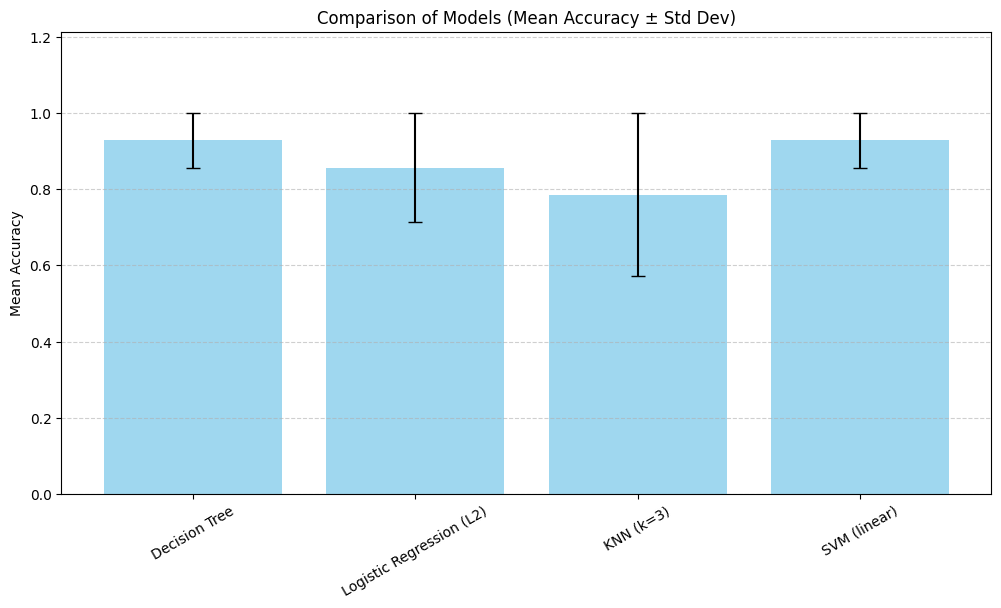

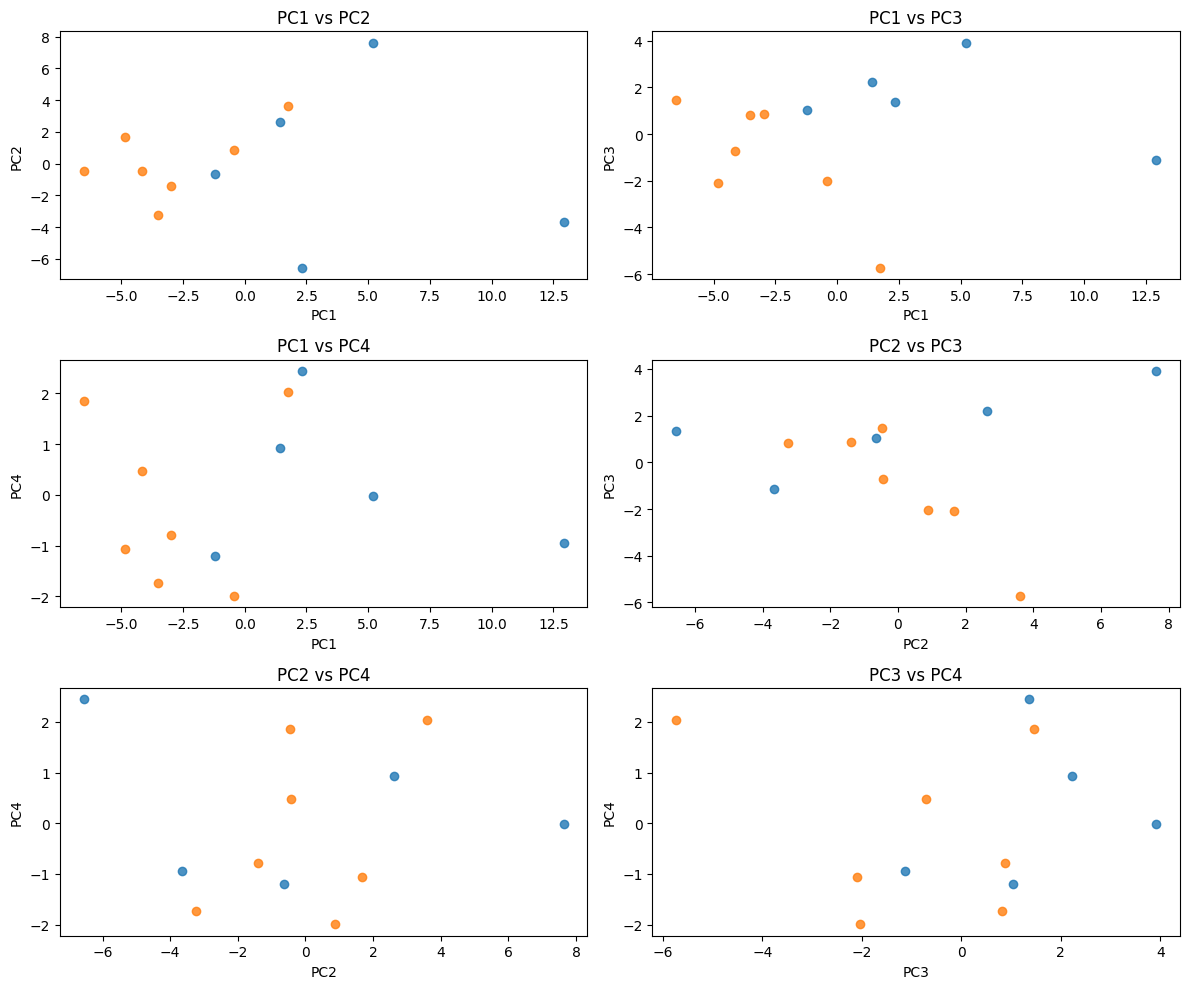

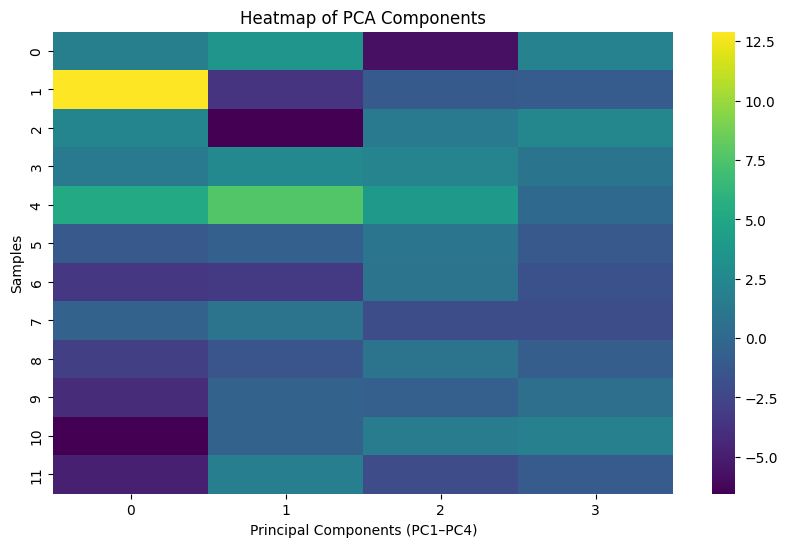

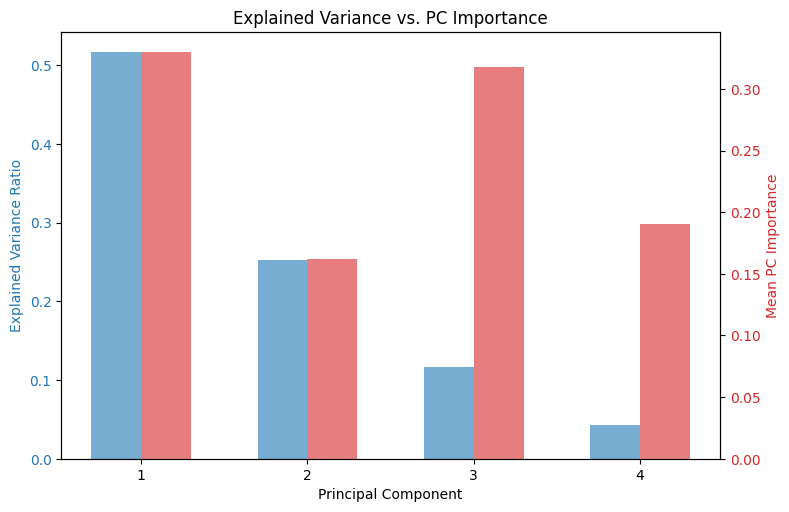

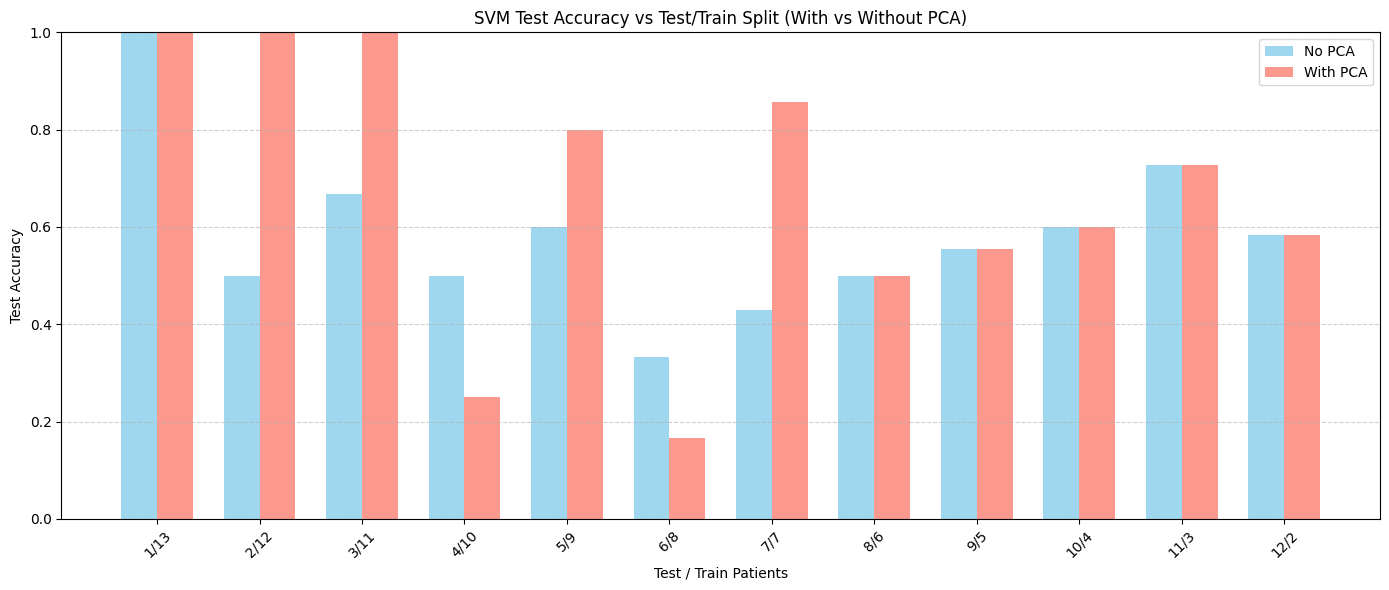

In [992]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression (L2)": LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "SVM (linear)": SVC(kernel='linear', C=1.0, random_state=42)
}

# Store results
results = {}

kf = KFold(n_splits=7, shuffle=True, random_state=42)
patient_ids = df_experiment_design.index.to_numpy()
labels_array = np.array(labels)

for model_name, model in models.items():
    accuracies = []
    
    for train_idx, test_idx in kf.split(patient_ids):
        train_samples = patient_ids[train_idx]
        test_samples = patient_ids[test_idx]
        
        healthy_train = df_experiment_design.loc[train_samples, "Sample Characteristic[disease]"] == "normal"
        disease_train = ~healthy_train
        
        mean_h = df_raw_counts[train_samples[healthy_train]].mean(axis=1)
        mean_d = df_raw_counts[train_samples[disease_train]].mean(axis=1)
        
        fold = (mean_d - mean_h).abs()
        top_genes = fold.nlargest(50).index
        
        X_train = df_raw_counts.loc[top_genes, train_samples].T.values
        X_test = df_raw_counts.loc[top_genes, test_samples].T.values
        
        y_train = labels_array[train_idx]
        y_test = labels_array[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        pca = PCA(n_components=4)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Train and predict
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    results[model_name] = {
        "mean_accuracy": np.mean(accuracies),
        "std_accuracy": np.std(accuracies)
    }

# Plot bar diagram
model_names = list(results.keys())
mean_accuracies = [results[m]["mean_accuracy"] for m in model_names]
std_accuracies = [results[m]["std_accuracy"] for m in model_names]

# Option 1: Clip error bars at 1.0 (accuracy cannot exceed 1)
yerr = [np.minimum(std_accuracies, 1 - np.array(mean_accuracies))]

# Option 2: Automatically expand y-axis to fit error bars
y_max = max(np.array(mean_accuracies) + np.array(std_accuracies)) * 1.1  # add 10% margin

plt.figure(figsize=(12,6))
plt.bar(model_names, mean_accuracies, yerr=yerr, capsize=5, color='skyblue', alpha=0.8)
plt.ylabel("Mean Accuracy")
plt.title("Comparison of Models (Mean Accuracy ± Std Dev)")
plt.ylim(0, y_max)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools
from pandas.plotting import parallel_coordinates

# Convert labels to numpy
labels_array = np.array(y_train)
pcs = X_train_pca  # shape: (n_samples, 4)

# Replace numeric labels 0/1 with readable names
label_names = {0: "Control", 1: "RRMS"}
label_colors = {0: 'blue', 1: 'red'}

pairs = list(itertools.combinations(range(4), 2))

plt.figure(figsize=(12, 10))
for i, (a, b) in enumerate(pairs):
    plt.subplot(3, 2, i+1)
    for label in np.unique(labels_array):
        plt.scatter(
            pcs[labels_array == label, a],
            pcs[labels_array == label, b],
            label=label_names[label],
            alpha=0.8
        )
    plt.xlabel(f"PC{a+1}")
    plt.ylabel(f"PC{b+1}")
    plt.title(f"PC{a+1} vs PC{b+1}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(pcs, cmap="viridis")
plt.title("Heatmap of PCA Components")
plt.xlabel("Principal Components (PC1–PC4)")
plt.ylabel("Samples")
plt.show()
pcs = np.arange(1, len(mean_importance) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.bar(pcs - 0.15, pca.explained_variance_ratio_, width=0.3, color=color, alpha=0.6, label='Explained Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(pcs)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mean PC Importance', color=color)
ax2.bar(pcs + 0.15, mean_importance, width=0.3, color=color, alpha=0.6, label='PC Importance')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Explained Variance vs. PC Importance")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Convert features and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_samples = len(y)
classes = np.unique(y)
n_classes = len(classes)

accuracies_no_pca = []
accuracies_pca = []
splits = []

# Shuffle indices once for reproducibility
np.random.seed(42)
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Loop over test set sizes from 1 to n_samples-1
for n_test in range(1, n_samples):
    n_train = n_samples - n_test
    
    # Skip train sets smaller than number of classes
    if n_train < n_classes:
        continue
    
    # Split manually
    test_idx = indices[:n_test]
    train_idx = indices[n_test:n_test+n_train]
    
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # ---- SVM without PCA ----
    model_no_pca = SVC(kernel='linear', random_state=42)
    model_no_pca.fit(X_train, y_train)
    y_pred_no_pca = model_no_pca.predict(X_test)
    acc_no_pca = accuracy_score(y_test, y_pred_no_pca)
    
    # ---- SVM with PCA ----
    n_components = min(4, X_train.shape[0], X_train.shape[1])
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model_pca = SVC(kernel='linear', random_state=42)
    model_pca.fit(X_train_pca, y_train)
    y_pred_pca = model_pca.predict(X_test_pca)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    
    # Store results
    accuracies_no_pca.append(acc_no_pca)
    accuracies_pca.append(acc_pca)
    splits.append(f"{n_test}/{n_train}")

# Plot side-by-side bar chart
x = np.arange(len(splits))
width = 0.35

plt.figure(figsize=(14,6))
plt.bar(x - width/2, accuracies_no_pca, width, label="No PCA", color='skyblue', alpha=0.8)
plt.bar(x + width/2, accuracies_pca, width, label="With PCA", color='salmon', alpha=0.8)

plt.xticks(x, splits, rotation=45)
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.xlabel("Test / Train Patients")
plt.title("SVM Test Accuracy vs Test/Train Split (With vs Without PCA)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot the covariance matrix
#plt.figure(figsize=(10, 8))
#plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest')
#plt.title('Covariance Matrix of Features')
#plt.colorbar()
#plt.xlabel('Features')
#plt.ylabel('Features')
#plt.savefig('covariance_matrix.png')
#print("Covariance matrix plot saved to covariance_matrix.png")

In [993]:
def get_single_gene_feature(df_filtered, df_experiment_design, gene): 
    """
    Get the single gene feature for all patients in the dataset.
    
    Parameters:
    df_filtered (pd.DataFrame): DataFrame containing raw gene counts.
    df_experiment_design (pd.DataFrame): DataFrame containing experiment design data.
    
    Returns: 
    tuple: Features and labels for the dataset.
    """
    patient_ids = df_experiment_design.index.to_list()

    gene_index = df_filtered.index.get_loc(gene)

    features = [df_filtered[patient_id][gene_index:gene_index + 1].to_list() for patient_id in patient_ids]
    labels = df_experiment_design["Sample Characteristic[disease]"].to_list()
    unique_labels = list(set(labels))
    labels = [unique_labels.index(label) for label in labels] # Convert labels to numbers
    return features, labels

single_feature, labels = get_single_gene_feature(df_filtered, df_experiment_design, "ENSG00000250696")

Number of patients: 14
Expression data shape: (14, 50)
Labels array shape: (14,)


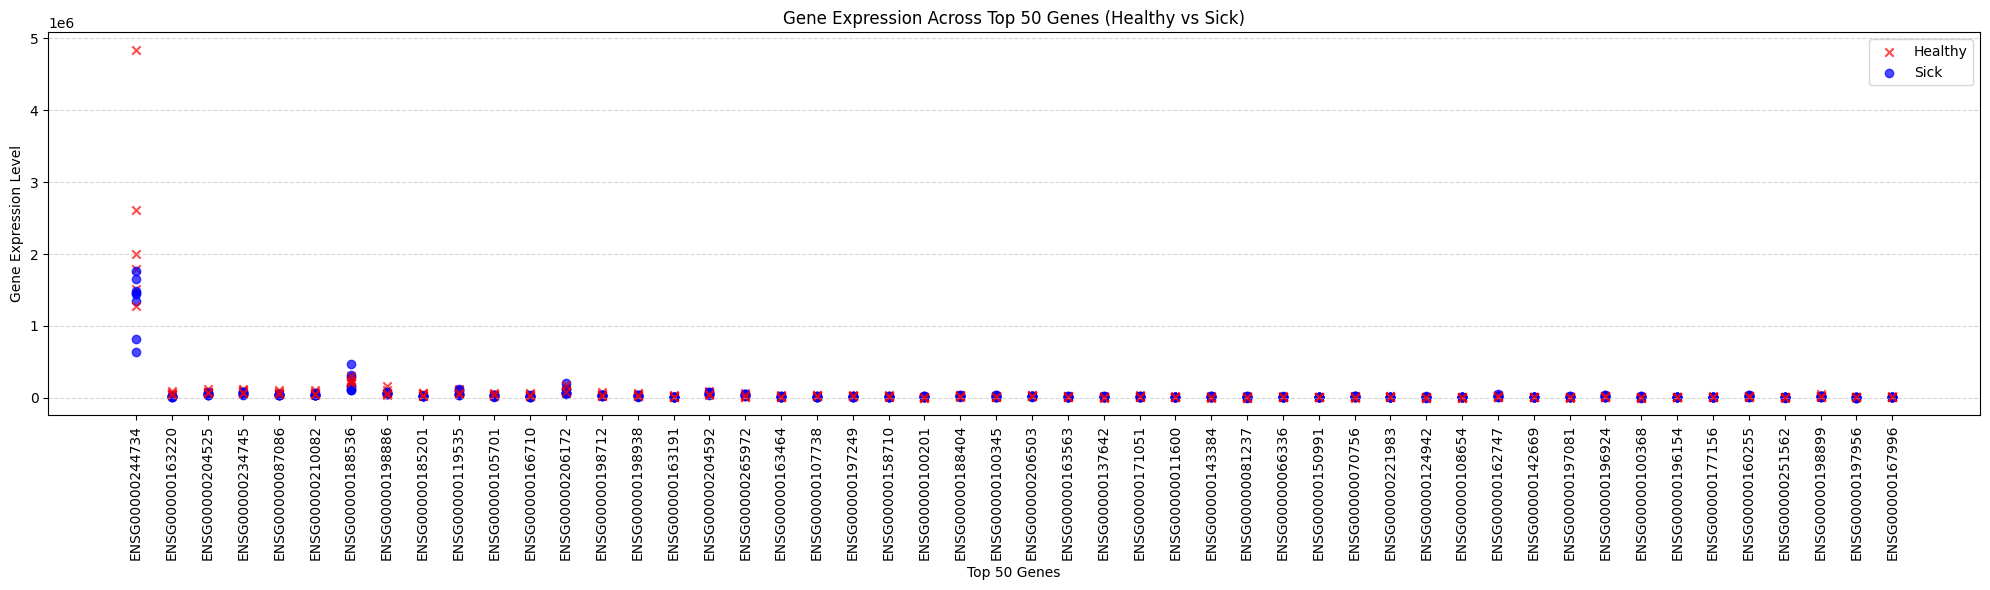

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Keep only patient columns that exist in both df_raw_counts and experiment design
patient_ids = [c for c in df_raw_counts.columns if c in df_experiment_design.index]

# Step 2: Align labels exactly to these patient_ids
labels_series = df_experiment_design.loc[patient_ids, "Sample Characteristic[disease]"]
labels_array = np.array([1 if x == positive_label else 0 for x in labels_series])

# Step 3: Compute top 50 genes
healthy_patients = labels_series[labels_series == negative_label].index.tolist()
sick_patients    = labels_series[labels_series == positive_label].index.tolist()

mean_h = df_raw_counts[healthy_patients].mean(axis=1)
mean_d = df_raw_counts[sick_patients].mean(axis=1)
top_genes = (mean_d - mean_h).abs().nlargest(50).index
top_genes = top_genes[1:]

# Step 4: Expression data for these patients
expression_data = df_raw_counts.loc[top_genes, patient_ids].T  # rows = patients, cols = genes

# Sanity check
print("Number of patients:", len(patient_ids))
print("Expression data shape:", expression_data.shape)
print("Labels array shape:", labels_array.shape)

x_vals = np.tile(np.arange(len(top_genes)), (expression_data.shape[0], 1))
y_vals = expression_data.values

plt.figure(figsize=(20,6))
for i in range(expression_data.shape[0]):
    marker = 'x' if labels_array[i] == 1 else 'o'
    color  = 'red' if labels_array[i] == 1 else 'blue'
    plt.scatter(x_vals[i, :], y_vals[i, :], marker=marker, color=color, alpha=0.7)

plt.xticks(range(len(top_genes)), top_genes, rotation=90)
plt.xlabel("Top 50 Genes")
plt.ylabel("Gene Expression Level")
plt.title("Gene Expression Across Top 50 Genes (Healthy vs Sick)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(['Healthy', 'Sick'], loc='upper right')
plt.tight_layout()
plt.show()
